In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from os import listdir
from os.path import isfile, join

inst_paths = ['/home/ubuntu/datasets/bach/piano', 
              '/home/ubuntu/datasets/bach/harp', 
              '/home/ubuntu/datasets/bach/violin'] 

inst_files_list = []
for inst_path in inst_paths:
    inst_files = [join(inst_path, f) for f in listdir(inst_path) if isfile(join(inst_path, f)) and f.endswith('npy')]
    inst_files_list.append(inst_files)

print(inst_files_list)


[['/home/ubuntu/datasets/bach/piano/piano_194.npy', '/home/ubuntu/datasets/bach/piano/piano_303.npy', '/home/ubuntu/datasets/bach/piano/piano_832.npy', '/home/ubuntu/datasets/bach/piano/piano_254.npy', '/home/ubuntu/datasets/bach/piano/piano_471.npy', '/home/ubuntu/datasets/bach/piano/piano_93.npy', '/home/ubuntu/datasets/bach/piano/piano_528.npy', '/home/ubuntu/datasets/bach/piano/piano_69.npy', '/home/ubuntu/datasets/bach/piano/piano_256.npy', '/home/ubuntu/datasets/bach/piano/piano_355.npy', '/home/ubuntu/datasets/bach/piano/piano_272.npy', '/home/ubuntu/datasets/bach/piano/piano_704.npy', '/home/ubuntu/datasets/bach/piano/piano_383.npy', '/home/ubuntu/datasets/bach/piano/piano_754.npy', '/home/ubuntu/datasets/bach/piano/piano_776.npy', '/home/ubuntu/datasets/bach/piano/piano_823.npy', '/home/ubuntu/datasets/bach/piano/piano_717.npy', '/home/ubuntu/datasets/bach/piano/piano_600.npy', '/home/ubuntu/datasets/bach/piano/piano_140.npy', '/home/ubuntu/datasets/bach/piano/piano_353.npy', 

In [3]:
T = 10000

inst_waves_list = []

inst_index = 0
for inst_files in inst_files_list:
    waves = []
    for inst_file in inst_files:
        wave = np.load(inst_file)
        if not len(wave) > 0 or len(wave) % T != 0:
            continue
            
        wave /= max(wave)            
        wave = np.resize(wave, [-1, T])

        for i in range(wave.shape[0]):
            waves.append(wave[i])
        
    waves = np.stack(waves)
    inst_waves_list.append(waves)
    inst_index += 1
    
for waves in inst_waves_list:
    print(waves.shape)
    
INSTRUMENTS_NUM = len(inst_waves_list)

(6034, 10000)
(5229, 10000)
(1722, 10000)


In [4]:
def mulaw(x, MU):
    return tf.sign(x) * tf.log(1. + MU * tf.abs(x)) / tf.log(1. + MU)

def inv_mulaw(x, MU):
    return tf.sign(x) * (1. / MU) * (tf.pow(1. + MU, tf.abs(x)) - 1.)
    
def naive_wavenet(inputs, condition, layers, h_filters, out_filters, name='naive_wavenet', reuse=False):
    with tf.variable_scope(name, reuse=reuse):
        
        outputs = tf.pad(inputs, [[0, 0], [1, 0], [0, 0]])
        outputs = tf.layers.conv1d(inputs=outputs, filters=h_filters, 
                                       kernel_size=2, dilation_rate=1, use_bias=False)
        dilation_sum = 1
        skips = []

        for layer in range(layers):
            dilation = 2 ** layer
            dilation_sum += dilation
            layer_outputs = tf.pad(outputs, [[0, 0], [dilation, 0], [0, 0]])
            filter_outputs = tf.layers.conv1d(inputs=layer_outputs, filters=h_filters, 
                                       kernel_size=2, dilation_rate=dilation, use_bias=False)
            gate_outputs = tf.layers.conv1d(inputs=layer_outputs, filters=h_filters, 
                                       kernel_size=2, dilation_rate=dilation, use_bias=False)
            if condition is not None:
                filter_condition = tf.layers.dense(condition, h_filters)
                gate_condition = tf.layers.dense(condition, h_filters)
            else:
                filter_condition = 0
                gate_condition = 0

            layer_outputs = tf.nn.tanh(filter_outputs + filter_condition) * \
                            tf.nn.sigmoid(gate_outputs + gate_condition)

            residual = tf.layers.dense(layer_outputs, h_filters)
            outputs += residual

            skip = tf.layers.dense(layer_outputs, h_filters)
            skips.append(skip)

        outputs = tf.nn.relu(sum(skips))
        outputs = tf.layers.dense(outputs, out_filters, activation=tf.nn.relu)
        outputs = tf.layers.dense(outputs, out_filters, activation=None)

    return dilation_sum, outputs

def downsample(inputs, pool_size, channel):
    #pad_size = (pool_size - 1) - (tf.shape(inputs)[1] - pool_size + 1) % pool_size
    #outputs = tf.pad(inputs, [[0, 0], [pad_size, 0], [0, 0]])
    outputs = tf.layers.average_pooling1d(inputs=inputs, pool_size=pool_size, strides=pool_size)
    #outputs = tf.reshape(outputs, [tf.shape(outputs)[0], tf.shape(outputs)[1], channel])
    pad_size = 1
    return pad_size, outputs

def upsample(inputs, output_size, channel):
    outputs = tf.expand_dims(inputs, axis=1)
    outputs = tf.image.resize_nearest_neighbor(outputs, [1, output_size])
    outputs = tf.squeeze(outputs, axis=1)
    outputs = tf.reshape(outputs, [tf.shape(outputs)[0], tf.shape(outputs)[1], channel])
    return outputs[:, -output_size:]

def domain_confusion(inputs, layers, domain_num, h_filters):
    outputs = inputs
    for layer in range(layers):
        dilation = 2 ** layers
        outputs = tf.layers.conv1d(inputs=outputs, filters=h_filters, kernel_size=2, 
                                   dilation_rate=1, activation=tf.nn.elu)
    
    outputs = tf.layers.dense(outputs, domain_num, activation=tf.nn.tanh)
    outputs = tf.layers.dense(outputs, domain_num)
    return outputs

print('done')

done


In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow.python.framework import ops


class FlipGradientBuilder(object):
    def __init__(self):
        self.num_calls = 0

    def __call__(self, x, l=1.0):
        grad_name = "FlipGradient%d" % self.num_calls
        @ops.RegisterGradient(grad_name)
        def _flip_gradients(op, grad):
            return [tf.negative(grad) * l]
        
        g = tf.get_default_graph()
        with g.gradient_override_map({"Identity": grad_name}):
            y = tf.identity(x)
            
        self.num_calls += 1
        return y
    
flip_gradient = FlipGradientBuilder()

In [6]:
# hyper-parameters
MU = 256
LATENT_DIM = 64
POOL_SIZE = 400


In [29]:
tf.reset_default_graph()

'''

INPUT LAYER

'''
# wave input
x_holder = tf.placeholder(dtype=tf.float32, shape=[None, None])
x_mulaw = mulaw(x_holder, MU)
x_onehot_index = tf.clip_by_value(tf.cast((x_mulaw + 1.) * 0.5 * MU, tf.int32), 0, MU - 1)
x_onehot = tf.one_hot(x_onehot_index, depth=MU)

# label input
label_holder = tf.placeholder(dtype=tf.int32, shape=())

'''

ENCODER LAYER

'''

# encode
_, latents = naive_wavenet(inputs=tf.expand_dims(x_holder, axis=-1), condition=None, 
                           layers=9, h_filters=64, out_filters=LATENT_DIM, name='wavenet_encoder')

# downsample
_, down_latents = downsample(latents, POOL_SIZE, LATENT_DIM)

# upsample
up_latents = upsample(down_latents, tf.shape(x_holder)[1], LATENT_DIM)

'''

DOMAIN CONFUSION LAYER

'''

# gradient reversal layer
flipped_down_latents = flip_gradient(down_latents)
#flipped_down_latents = down_latents

# domain predict
label_predicts = domain_confusion(flipped_down_latents, 3, INSTRUMENTS_NUM, 128)
label_predicts = tf.reduce_mean(label_predicts, axis=1)
label_predicts_prob = tf.nn.softmax(label_predicts)
label_tiled = tf.tile(tf.expand_dims(label_holder, axis=0), [tf.shape(label_predicts)[0]])

# loss
domain_confusion_loss = tf.losses.sparse_softmax_cross_entropy(labels=label_tiled, logits=label_predicts)

'''

DECODER LAYER for traininng

'''
decode_losses = []
samples_list = []
for instrument_index in range(INSTRUMENTS_NUM):
    # decode
    dilation_sum, outputs = naive_wavenet(inputs=x_onehot, condition=up_latents, 
                                          layers=9, h_filters=64, out_filters=MU, 
                                          name='wavenet_decoder_' + str(instrument_index))
    outputs_probs = tf.nn.softmax(outputs)
    
    # sample from outputs
    dist = tf.distributions.Categorical(probs=outputs_probs)
    samples = inv_mulaw(tf.cast(dist.sample(), tf.float32) / MU * 2. - 1., MU)
    samples_list.append(samples)

    # loss
    decode_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=x_onehot_index[:, dilation_sum + 1:],
                                                                 logits=outputs[:, dilation_sum:-1])
    decode_loss = tf.reduce_mean(decode_loss)
    decode_losses.append(decode_loss)

decode_losses = tf.stack(decode_losses, axis=0) * tf.one_hot(label_holder, depth=INSTRUMENTS_NUM)
decode_losses = tf.reduce_mean(decode_losses)

loss = decode_losses + 1e-2 * domain_confusion_loss
train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)

'''

DECODER LAYER for inference

'''

# input for decoder
latents_holder = tf.placeholder(dtype=tf.float32, shape=[None, None, LATENT_DIM])

inference_sample_list = []

for instrument_index in range(INSTRUMENTS_NUM):
    # decode
    _, outputs = naive_wavenet(inputs=x_onehot, condition=latents_holder, 
                               layers=9, h_filters=64, out_filters=MU, 
                               name='wavenet_decoder_' + str(instrument_index), reuse=True)
    outputs_probs = tf.nn.softmax(outputs)

    # sample from outputs
    dist = tf.distributions.Categorical(probs=outputs_probs[:, -1])
    sample = inv_mulaw(tf.cast(dist.sample(), tf.float32) / MU * 2. - 1., MU)
    inference_sample_list.append(sample)

'''

SESSION CREATE

'''

config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )
sess = tf.Session(config=config)

#sess = tf.Session()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
# Restore variables from disk.
saver.restore(sess, "./music_trans/model17.ckpt")
print("Model restored.")

print('Tensorflow graph created.')


INFO:tensorflow:Restoring parameters from ./music_trans/model17.ckpt
Model restored.
Tensorflow graph created.


In [30]:
def pitch_shift(inputs, start_index, end_index, n_steps):
    shifted = librosa.effects.pitch_shift(inputs[start_index:end_index], 8000, n_steps)
    outputs = np.concatenate([inputs[:start_index], shifted, inputs[end_index:]], axis=0)
    return outputs

def wave_augmentation(inputs):
    length = np.random.randint(2000, 4000, 1)[0]
    start_index = np.random.randint(0, len(inputs) - length, 1)[0]
    end_index = start_index + length
    n_steps = float(np.random.ranf(1)[0] - 0.5)
    return pitch_shift(inputs, start_index, end_index, n_steps)

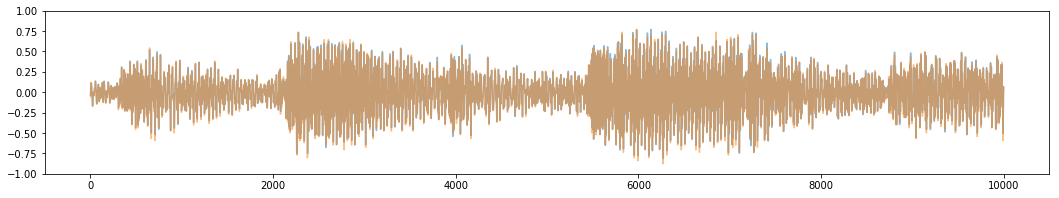

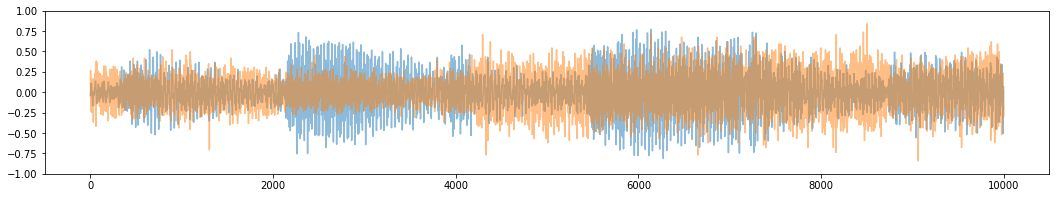

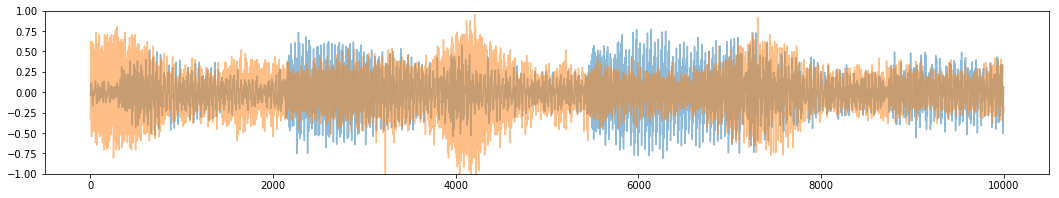

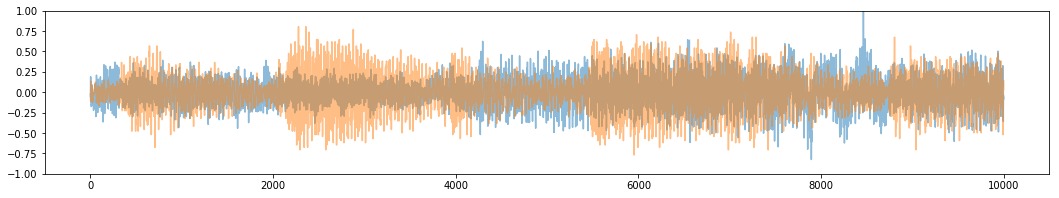

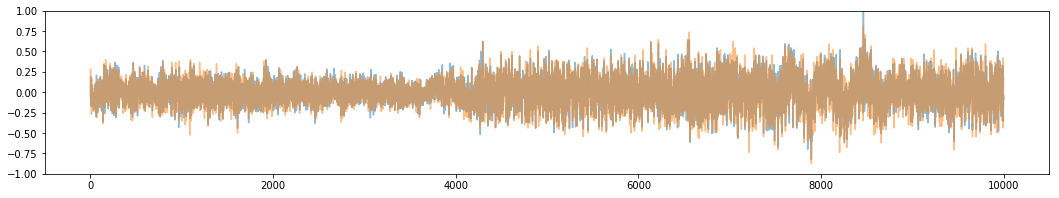

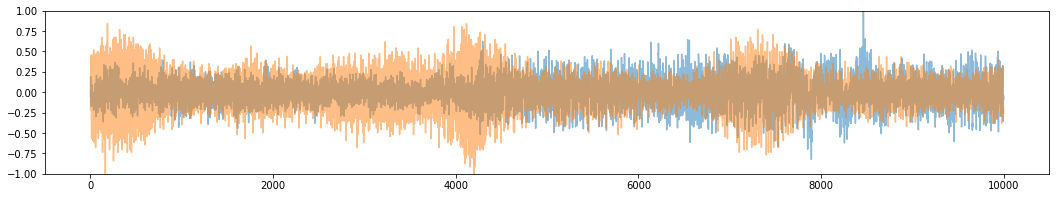

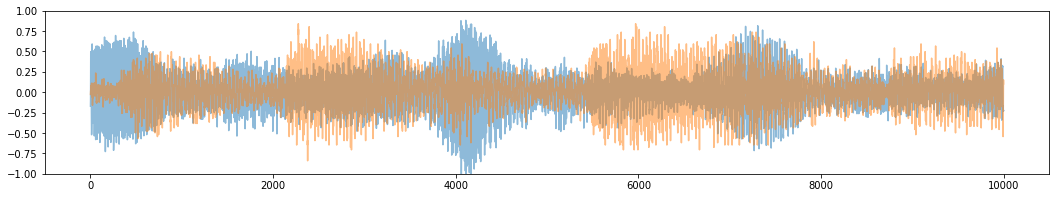

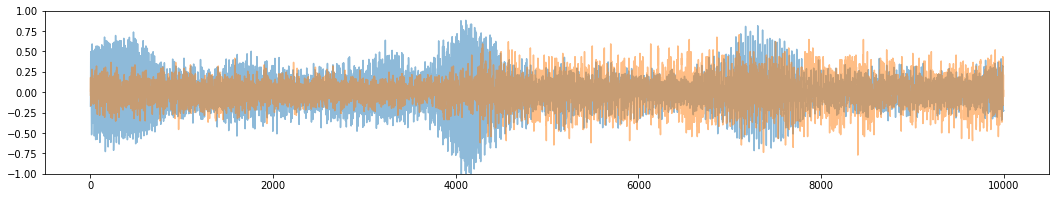

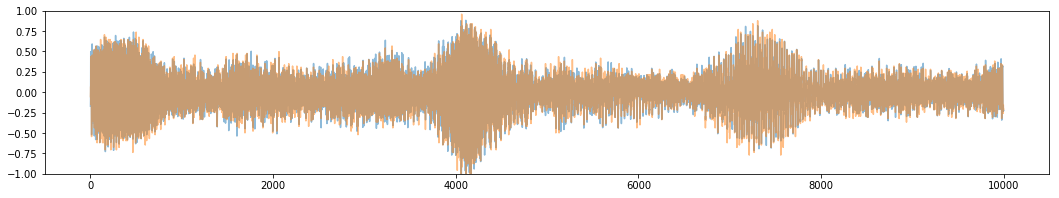

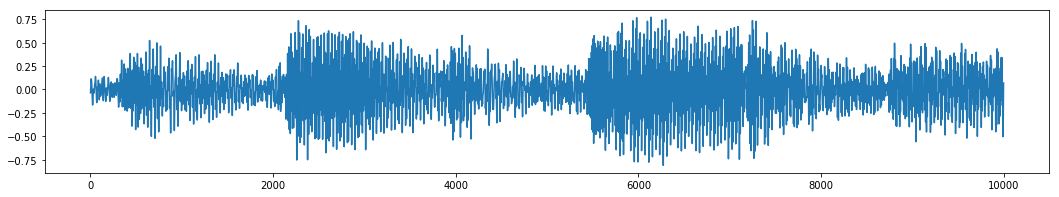

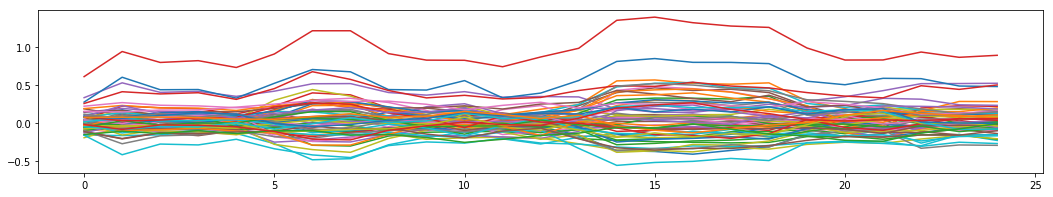

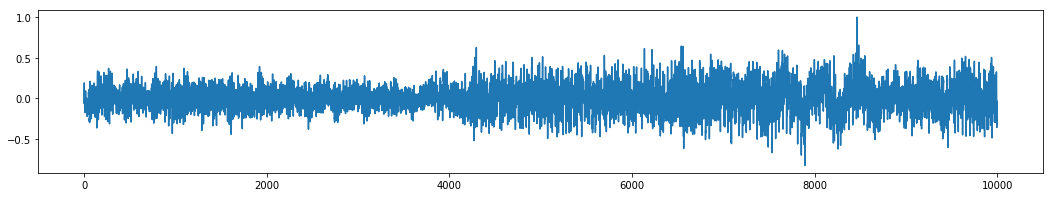

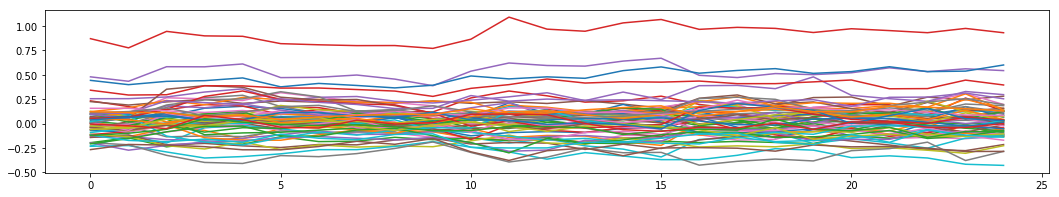

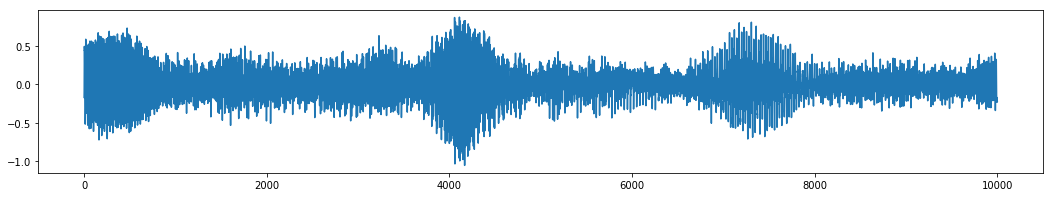

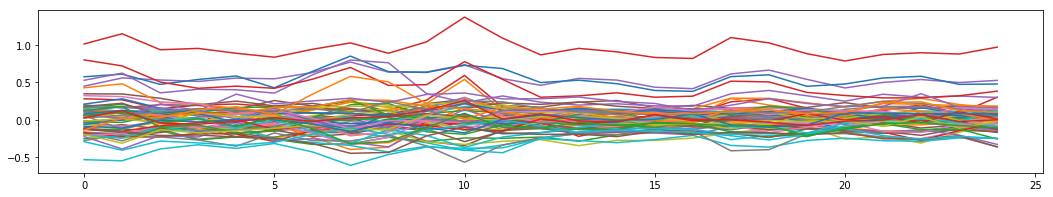

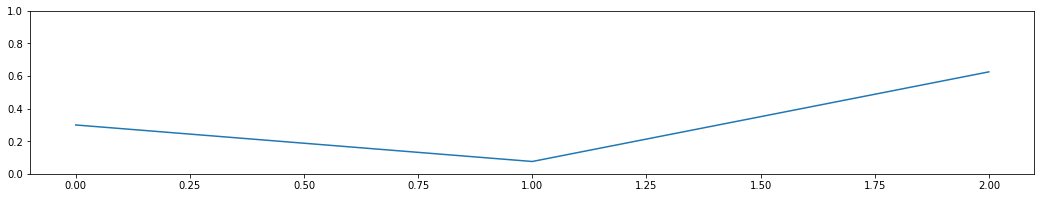

KeyboardInterrupt: 

In [15]:
from IPython.display import clear_output

while(True):
    for i in range(1):
        for instrument_index in range(INSTRUMENTS_NUM):
            batch_size = 3
            indexes = np.random.randint(0, inst_waves_list[instrument_index].shape[0], batch_size)
            augmented = []
            for _wave in inst_waves_list[instrument_index][indexes]:
                augmented.append(wave_augmentation(_wave))
            augmented = np.stack(augmented, axis=0)
            _, _loss = sess.run([train_step, loss], feed_dict={x_holder: augmented,
                                                     label_holder: instrument_index})
            print(i, _loss)
        
    clear_output()
    
    inst_waves_test = []
    for instrument_index in range(INSTRUMENTS_NUM):
        index = np.random.randint(0, inst_waves_list[instrument_index].shape[0], 1)
        inst_waves_test.append(inst_waves_list[instrument_index][index])
    
    inst_waves_test = np.vstack(inst_waves_test)
    _down_latents, _label_predicts_prob, _samples_list = sess.run([down_latents, label_predicts_prob, samples_list], 
                                                   feed_dict={x_holder: inst_waves_test})
    
    for instrument_index1 in range(INSTRUMENTS_NUM):
        for instrument_index2 in range(INSTRUMENTS_NUM):
            plt.figure(figsize=[18, 3])
            plt.plot(inst_waves_test[instrument_index1], alpha=0.5)
            plt.plot(_samples_list[instrument_index1][instrument_index2], alpha=0.5)
            plt.ylim([-1., 1.])
            plt.show()
    
    for _down_latent, inst_waves_test1 in zip(_down_latents, inst_waves_test):
        plt.figure(figsize=[18, 3])
        plt.plot(inst_waves_test1)
        plt.show()
        
        plt.figure(figsize=[18, 3])
        plt.plot(_down_latent)
        plt.show()
        
    plt.figure(figsize=[18, 3])
    plt.plot(_label_predicts_prob[0, :])
    plt.ylim([0., 1.])
    plt.show()
    

In [49]:
src_instrument_index = 2
dest_instrument_index = 0

In [50]:
index = np.random.randint(0, inst_waves_list[src_instrument_index].shape[0], 1)

(1, 10000, 64)


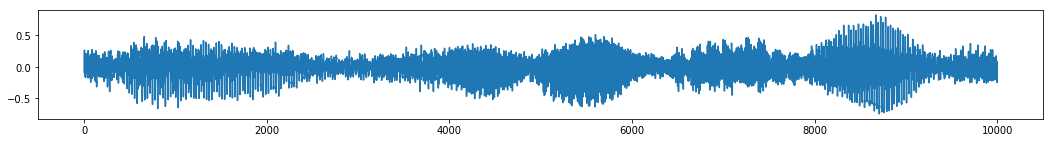

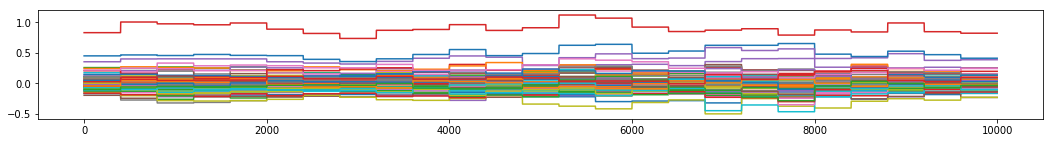

In [ ]:
_src = inst_waves_list[src_instrument_index][index]

_latents = sess.run(up_latents, feed_dict={x_holder: _src})

print(_latents.shape)

plt.figure(figsize=[18, 2])
plt.plot(_src[0])
plt.show()

plt.figure(figsize=[18, 2])
plt.plot(_latents[0])
plt.show()

import IPython.display as ipd
ipd.Audio(_src[0], rate=8000) # load a NumPy array

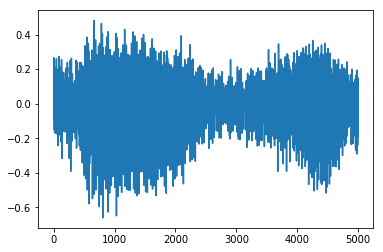

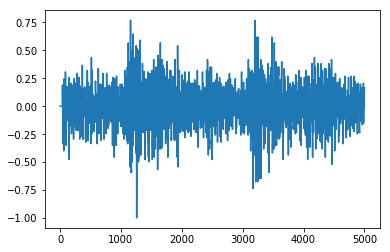

 51%|█████▏    | 5126/10000 [03:52<03:41, 22.01it/s]

In [ ]:
from tqdm import tqdm
from IPython.display import clear_output

_samples = np.zeros([1, 1024])
_latents = np.concatenate([np.zeros([1, 1024, LATENT_DIM]), _latents], axis=1)
for i in tqdm(range(T)):
    _inference_sample_list = sess.run(inference_sample_list, feed_dict={x_holder: _samples[:, -1024:], 
                                                                        latents_holder: _latents[:, i:i + 1024]})
    _samples = np.concatenate([_samples, np.expand_dims(_inference_sample_list[dest_instrument_index], axis=0)], axis=-1)
    if i % 200 == 0:
        clear_output()
        plt.plot(_src[0, :i])
        plt.show()
        
        plt.plot(_samples[0, 1024:])
        plt.show()

print(_samples.shape)


In [ ]:
import IPython.display as ipd
ipd.Audio(_src[0], rate=8000) # load a NumPy array


In [48]:
ipd.Audio(_samples[0], rate=8000) # load a NumPy array